## Load the data


In [32]:
import pandas as pd

accelerometer_df = pd.read_csv('/content/sample_data/accelerometer.csv')
gyroscope_df = pd.read_csv('/content/sample_data/gyroscope.csv')

display(accelerometer_df.head())
display(gyroscope_df.head())

,z,y,x,pose
0,-0.010821999981999397,0.04296,0.040719,twisting
1,-0.010821999981999397,0.04296,0.040719,twisting
2,-0.010821999981999397,0.04296,0.040719,twisting
3,-0.010821999981999397,0.04296,0.040719,twisting
4,-0.010821999981999397,0.04296,0.040719,twisting


,z,y,x,pose
0,0.029975000768899918,-0.053075,0.065725,twisting
1,0.017875000834465027,-0.081262,0.085250,twisting
2,-0.006599999964237213,-0.095837,0.096250,twisting
3,-0.018837500363588333,-0.082500,0.106013,twisting
4,-0.020075000822544098,-0.065312,0.109725,twisting


## Combine and preprocess the data


In [33]:
merged_df = pd.merge(accelerometer_df, gyroscope_df, left_index=True, right_index=True, suffixes=('_accel', '_gyro'))

merged_df = merged_df.drop('pose_gyro', axis=1)
merged_df = merged_df.rename(columns={'pose_accel': 'pose'})

for col in ['z_accel', 'y_accel', 'x_accel', 'z_gyro', 'y_gyro', 'x_gyro']:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

merged_df = merged_df.dropna()

X = merged_df.drop('pose', axis=1)
y = merged_df['pose']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

display(X_scaled_df.head())
display(y.head())

,z_accel,y_accel,x_accel,z_gyro,y_gyro,x_gyro
0,-0.027558,0.32678,0.045768,0.074080,-0.062106,0.116598
1,-0.027558,0.32678,0.045768,0.038686,-0.105920,0.157749
2,-0.027558,0.32678,0.045768,-0.032905,-0.128575,0.180932
3,-0.027558,0.32678,0.045768,-0.068701,-0.107843,0.201508
4,-0.027558,0.32678,0.045768,-0.072321,-0.081128,0.209332


,pose
0,twisting
1,twisting
2,twisting
3,twisting
4,twisting


## Visualize the data


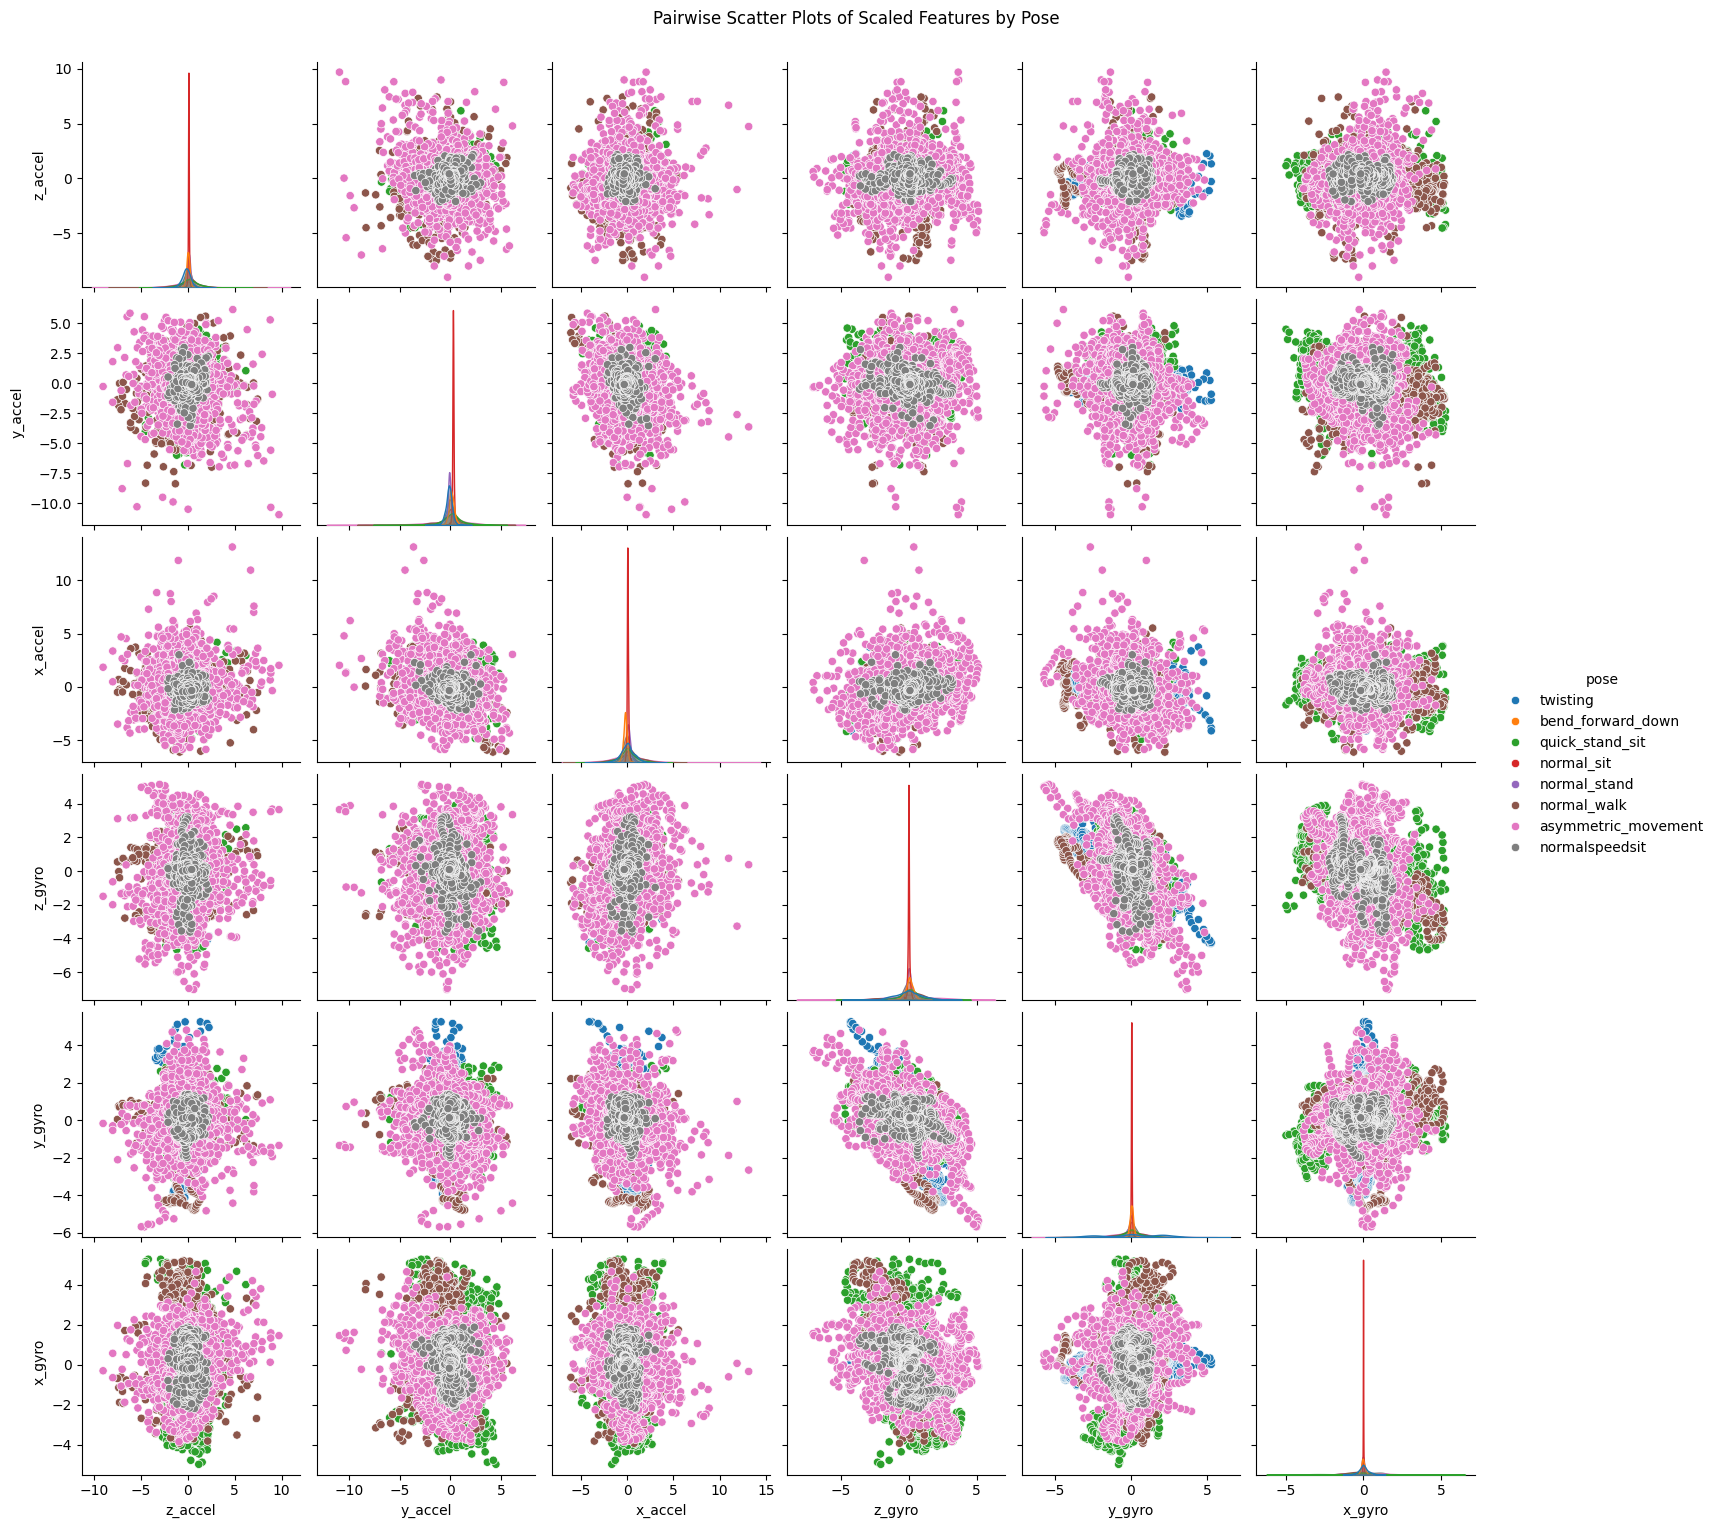


Correlation Matrix of Scaled Features:


,z_accel,y_accel,x_accel,z_gyro,y_gyro,x_gyro
z_accel,1.000000,-0.030507,0.128143,0.076082,0.032060,0.021919
y_accel,-0.030507,1.000000,-0.210833,-0.002094,0.002257,-0.091391
x_accel,0.128143,-0.210833,1.000000,0.264277,-0.208977,-0.094327
z_gyro,0.076082,-0.002094,0.264277,1.000000,-0.532616,-0.363640
y_gyro,0.032060,0.002257,-0.208977,-0.532616,1.000000,0.163168
x_gyro,0.021919,-0.091391,-0.094327,-0.363640,0.163168,1.000000


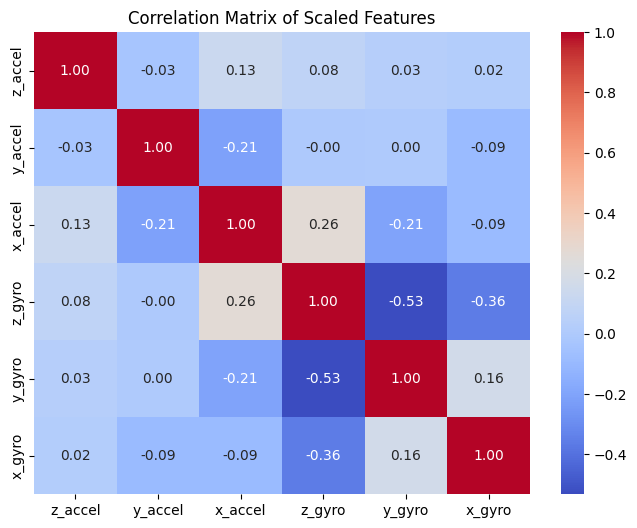

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

X_scaled_df_viz = X_scaled_df.copy()
X_scaled_df_viz['pose'] = y.values

sns.pairplot(X_scaled_df_viz, hue='pose')
plt.suptitle('Pairwise Scatter Plots of Scaled Features by Pose', y=1.02)
plt.show()

correlation_matrix = X_scaled_df.corr()
print("\nCorrelation Matrix of Scaled Features:")
display(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scaled Features')
plt.show()

## Split the data



In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (14058, 6)
Testing set shape: (3515, 6)


## Build and train a Random Forest model


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

print("Random Forest Classifier trained successfully.")

Random Forest Classifier trained successfully.


## Evaluate the model



In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

Accuracy: 0.8060
Precision (weighted): 0.8103
Recall (weighted): 0.8060
F1-score (weighted): 0.8061


## Determine feature importance


In [38]:

feature_importances = rf_classifier.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Overall Feature Importances:")
display(feature_importance_df)

Overall Feature Importances:


,Feature,Importance
5,x_gyro,0.207463
4,y_gyro,0.185685
1,y_accel,0.180592
2,x_accel,0.161976
0,z_accel,0.134967
3,z_gyro,0.129318
